dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (1, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (2, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (2, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (3, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (3, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

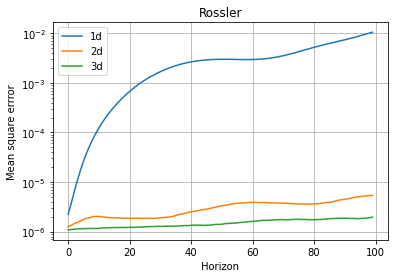

dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (1, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (2, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (2, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (3, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (3, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

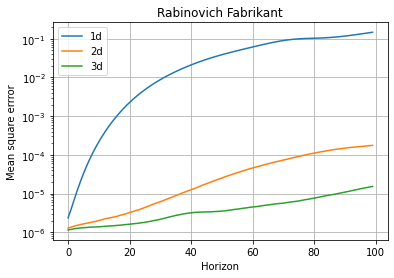

dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (1, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (2, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (2, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (3, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (3, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

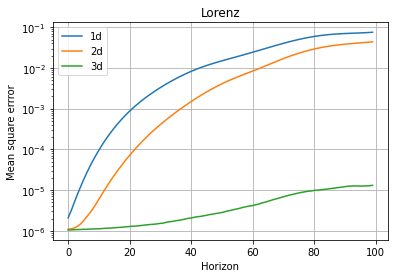

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
plt.ion()
%matplotlib inline



class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))


path = 'result/predict_x'
if not os.path.exists(path):
    os.makedirs(path)


seed = 42
for system_name in ['Rossler', 'Rabinovich Fabrikant','Lorenz']:
    # system_name = 'Rabinovich Fabrikant'
    # system_name = 'Lorenz'

    random.seed(seed) 
    np.random.seed(seed)


    mses = [[] for _ in range(3)]
    for dim in range(1,4):
        U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[:dim]
        U = U0 + np.random.randn(*U0.shape)*1e-3
        U = np.atleast_2d(U)
        num_prepare = 1000
        train_start = num_prepare
        num_train = 10000
        val_start = num_prepare + num_train
        num_val = 1000
        test_start = num_prepare + num_train + num_val
        num_test = 5000
        print('dataset shape:', U.shape)


        inSize = U.shape[0]
        outSize = inSize  
        resSize = 1000
        a = 0.9           # leaking rate
        K = 0.99          # spectial redius
        reg = 1e-6       # regularization coefficient 
        input_scaling = 1


        # generation of random weights
        Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
        W = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])
        W = W/rhoW*(K-1+a)/a 
        X = np.zeros((resSize,U.shape[1]))

        is_transient = True
        initial_transients = [np.zeros([resSize,1]), np.ones([resSize,1]), -np.ones([resSize,1])]
        x = initial_transients[0]

        for t in tqdm(range(U.shape[1])):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
            X[:,t:t+1] = x


        # offline train
        U_train = U[:,train_start : train_start + num_train]
        X_train = X[:,train_start : train_start + num_train]
        Y_train = U[:,train_start + 1 : train_start + num_train + 1]
        H = np.vstack((np.ones((1,X_train.shape[1])),X_train))



        Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
        print('pre_output shape:', H.shape)
        print('W_out shape:', Wout.shape)


        horizon = 100

        for h in tqdm(range(horizon)):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
            H = np.vstack((np.ones((1,num_test)),X_test))
            Y_pred = Wout @ H
            Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
            mses[dim-1].append(np.average(np.square(Y_pred - Y_true)[0]))

    labels=['1d','2d','3d']
    for i in range(3):
        plt.plot(mses[i], label=labels[i])
    plt.yscale('log')
    plt.xlabel('Horizon')
    plt.ylabel('Mean square errror')
    plt.title(system_name)
    plt.legend(loc='upper left')
    plt.grid('on')
    plt.savefig(path+'/multipred_'+system_name+'.pdf')
    plt.show()

In [2]:


plt.close('all')

def lighter(clr, f=1/3):
    """
    An implementation of Mathematica's Lighter[] 
    function for RGB colors
    clr : 3-tuple or list, an RGB color
    f : float, the fraction by which to brighten
    """
    gaps = [f*(1 - val) for val in clr]
    new_clr = [val + gap for gap, val in zip(gaps, clr)]
    return new_clr

def plot3dproj(x, y, z, *args, color=(0,0,0), shadow_dist=1.0, color_proj=None, 
    elev_azim=(39,-47), show_labels=True, **kwargs):
    """
    Create a three dimensional plot, with projections onto the 2D coordinate
    planes
    
    Parameters
    ----------
    x, y, z : 1D arrays of coordinates to plot
    *args : arguments passed to the matplotlib plt.plot functions
    - color : length-3 tuple
        The RGB color (with each element in [0,1]) to use for the
        three dimensional line plot
    - color_proj : length-3 tuple
        The RGB color (with each element in [0,1]) to use for the
        two dimensional projection plots. Defaults to a lighter version of the 
        plotting color
    - shadow_dist : float
        The relative distance of axes to their shadow. If a single value, 
        then the same distance is used for all three axies. If a triple, then 
        different values are used for all axes
    - elev_azim : length-2 tuple
        The starting values of elevation and azimuth when viewing the figure
    - show_labels : bool
        Whether to show numerical labels on the axes
    """

    if not color_proj:
        color_proj = lighter(color, .6)


    if np.isscalar(shadow_dist) == 1:
        sdist_x = shadow_dist
        sdist_y = shadow_dist
        sdist_z = shadow_dist
    else:
        sdist_x, sdist_y, sdist_z = shadow_dist

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection= '3d')
    
    ax.plot(x, z, *args, zdir='y', zs=sdist_y*np.max(y), color=color_proj, **kwargs)
    ax.plot(y, z, *args, zdir='x', zs=sdist_x*np.min(x), color=color_proj, **kwargs)
    ax.plot(x, y, *args, zdir='z', zs=sdist_z*np.min(z), color=color_proj, **kwargs)
    ax.plot(x, y, z, *args, color=color, **kwargs)

    ax.view_init(elev=elev_azim[0], azim=elev_azim[1])
    ax.set_aspect('auto', adjustable='box') 
    
#     ratio = 1.0
#     xvals, yvals = ax.get_xlim(), ax.get_ylim()
#     xrange = xvals[1]-xvals[0]
#     yrange = yvals[1]-yvals[0]
#     ax.set_aspect(ratio*(xrange/yrange), adjustable='box')

    if not show_labels:
        ax.set_xticklabels([])                               
        ax.set_yticklabels([])                               
        ax.set_zticklabels([])
    #plt.show()

    return ax
    


(20000,)


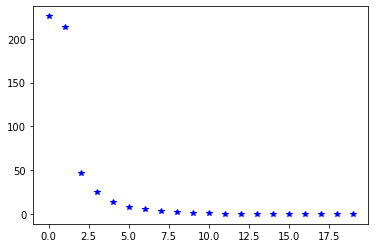

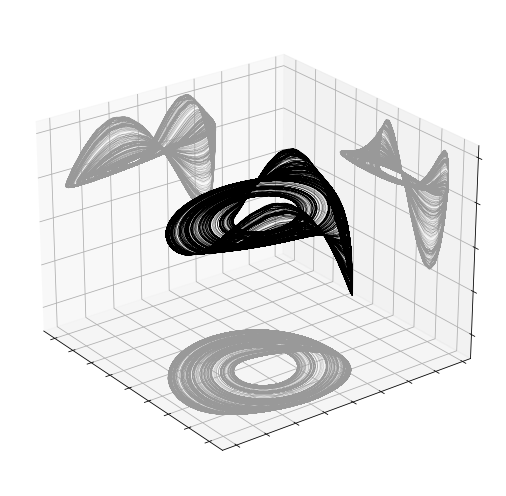

In [25]:
system_name = 'Rossler'
# system_name = 'Rabinovich Fabrikant'
# system_name = 'Lorenz'


U0 = np.loadtxt('dataset/'+system_name+'.csv', delimiter=',').T[0]
print(U0.shape)
nrows = 20
ncols = 19000
ustack = np.vstack([ U0[i:i+ncols] for i in range(nrows)])


Ml, Diag, Mr = np.linalg.svd(ustack, full_matrices=False)
plt.plot(Diag, 'b*', label='sigular values')

N_v = 3
# Mr = ustack
plot3dproj(Mr[0], Mr[1], Mr[3], shadow_dist=2, elev_azim=(25,-37), linewidth=.15, show_labels=False)
plt.tight_layout()
plt.show()
# plt.plot(Mr[:3].T)

dataset shape: (1, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (1, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (10, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (10, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (20, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (20, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (30, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (30, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (40, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (40, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (50, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (50, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (60, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (60, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (70, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (70, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (80, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (80, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (90, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (90, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

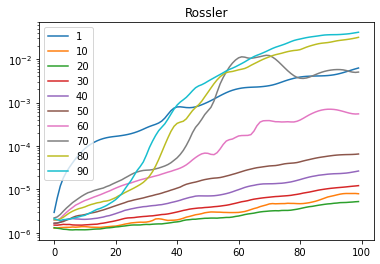

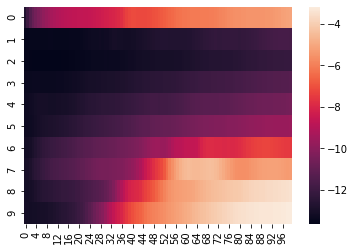

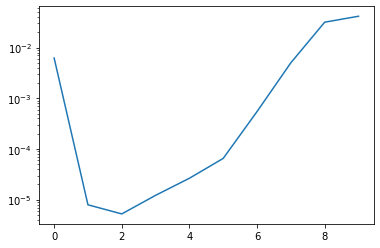

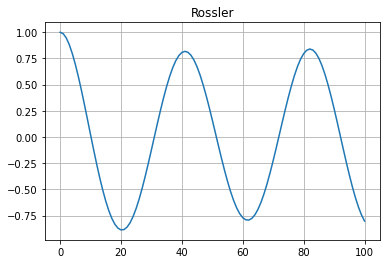

dataset shape: (1, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (1, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (10, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (10, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (20, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (20, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (30, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (30, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (40, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (40, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (50, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (50, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (60, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (60, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (70, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (70, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (80, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (80, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (90, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (90, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

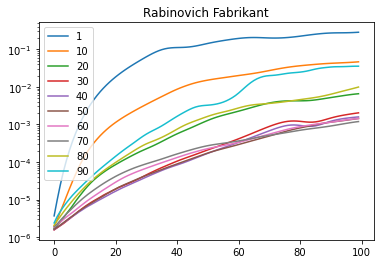

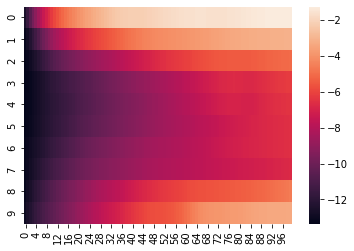

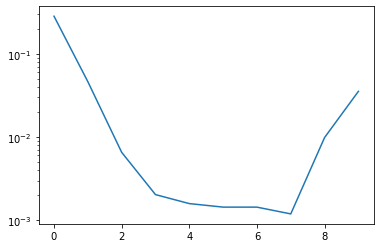

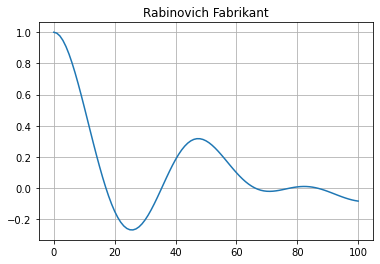

dataset shape: (1, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (1, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (10, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (10, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (20, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (20, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (30, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (30, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (40, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (40, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (50, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (50, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (60, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (60, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (70, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (70, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (80, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (80, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (90, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (1001, 10000)
W_out shape: (90, 1001)


  0%|          | 0/100 [00:00<?, ?it/s]

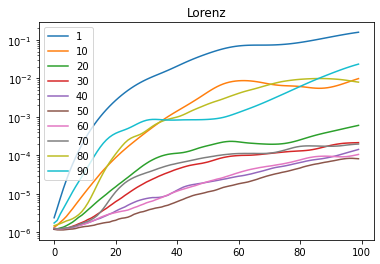

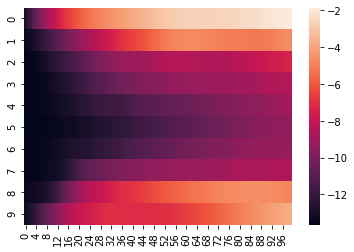

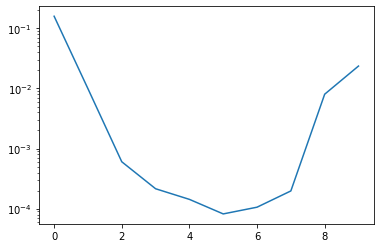

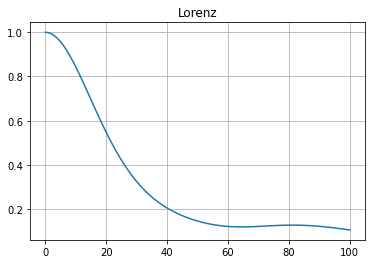

In [54]:

for system_name in ['Rossler', 'Rabinovich Fabrikant','Lorenz']:
    
    U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[0]

    nhistory = [1] + [10*i for i in range(1,10)]
    mse_history = [[] for _ in range(len(nhistory))]

    for i,nrows in enumerate(nhistory):

        ncols = 19000
        ustack = np.vstack([ U0[i:i+ncols] for i in range(nrows)])

        U1 = np.vstack([ustack[-1], ustack[:-1]])


        U = U1 + np.random.randn(*U1.shape)*1e-3
        U = np.atleast_2d(U)
        num_prepare = 1000
        train_start = num_prepare
        num_train = 10000
        val_start = num_prepare + num_train
        num_val = 1000
        test_start = num_prepare + num_train + num_val
        num_test = 5000
        print('dataset shape:', U.shape)

        seed = 42
        random.seed(seed) 
        np.random.seed(seed)

        inSize = U.shape[0]
        outSize = inSize  
        resSize = 1000
        a = 1         # leaking rate
        K = 0.99          # spectial redius
        reg = 1e-6       # regularization coefficient 
        input_scaling = 1

        # generation of random weights
        Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
        W = np.random.rand(resSize,resSize)-0.5

        largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])
        W = W/rhoW*(K-1+a)/a 
        X = np.zeros((resSize,U.shape[1]))

        is_transient = True
        initial_transients = [np.zeros([resSize,1]), np.ones([resSize,1]), -np.ones([resSize,1])]
        x = initial_transients[0]

        for t in tqdm(range(U.shape[1])):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
            X[:,t:t+1] = x


        # offline train
        U_train = U[:,train_start : train_start + num_train]
        X_train = X[:,train_start : train_start + num_train]
        Y_train = U[:,train_start + 1 : train_start + num_train + 1]
        H = np.vstack((np.ones((1,X_train.shape[1])),X_train))



        Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
        print('pre_output shape:', H.shape)
        print('W_out shape:', Wout.shape)


        horizon = 100

        for h in tqdm(range(horizon)):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
            H = np.vstack((np.ones((1,num_test)),X_test))
            Y_pred = Wout @ H
            Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
            mse_history[i].append(np.average(np.square(Y_pred - Y_true)[0]))
            
    for i in range(len(nhistory)):
        plt.plot(mse_history[i], label=str(nhistory[i]))  
    plt.yscale('log')
    plt.title(system_name)
    plt.legend()
    plt.show()

    sns.heatmap(np.log(np.array(mse_history)))
    plt.show()

    plt.plot(np.array(mse_history)[:,-1])
    plt.yscale('log')
    import statsmodels.tsa.api as smt
    acf = smt.stattools.acf(U0,nlags=100,fft=True)
    plt.figure()
    plt.title(system_name)
    plt.plot(acf)
    plt.grid('on')
    plt.show()


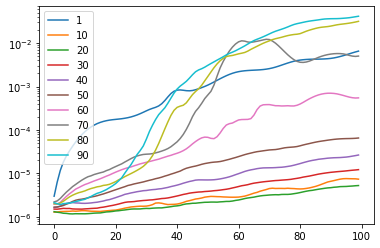

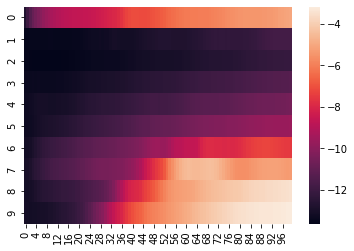

In [28]:
for i in range(len(nhistory)):
    plt.plot(mse_history[i], label=str(nhistory[i]))
    
plt.yscale('log')
plt.legend()

plt.show()


sns.heatmap(np.log(np.array(mse_history)))
plt.show()

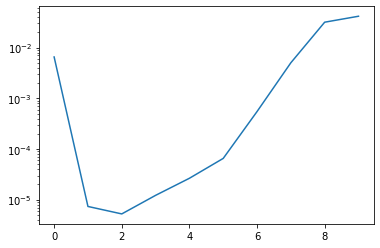

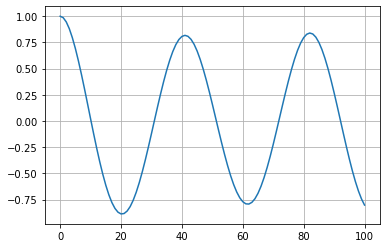

In [29]:
plt.plot(np.array(mse_history)[:,-1])
plt.yscale('log')
import statsmodels.tsa.api as smt
acf = smt.stattools.acf(U0,nlags=100,fft=True)
plt.figure()
plt.plot(acf)
plt.grid('on')

(90, 19000)


  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 2000)


D:\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


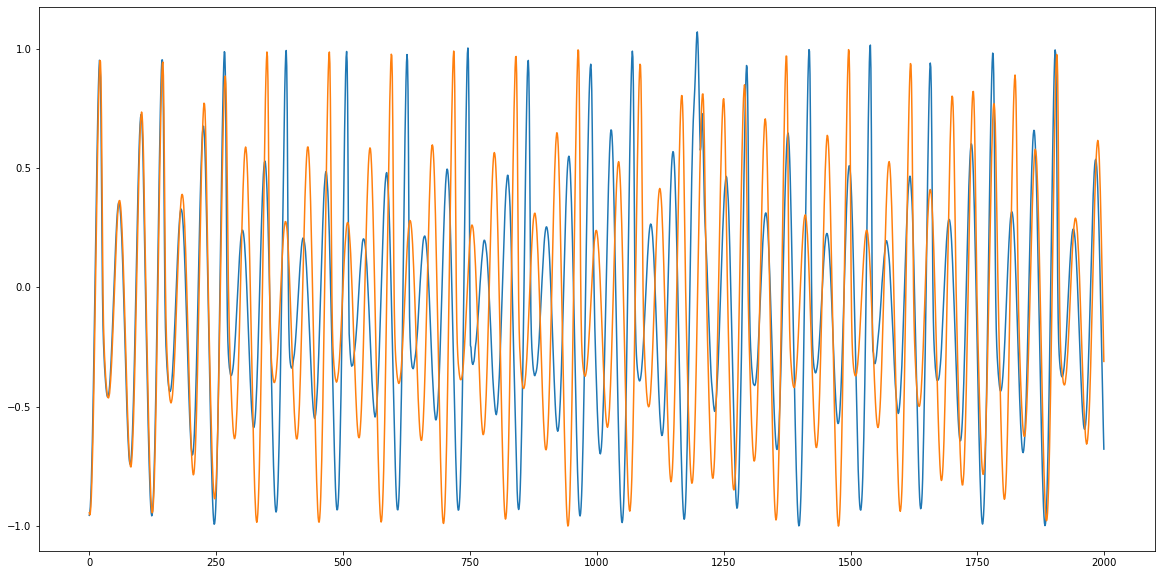

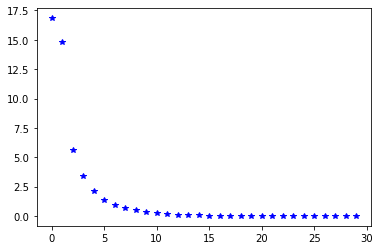

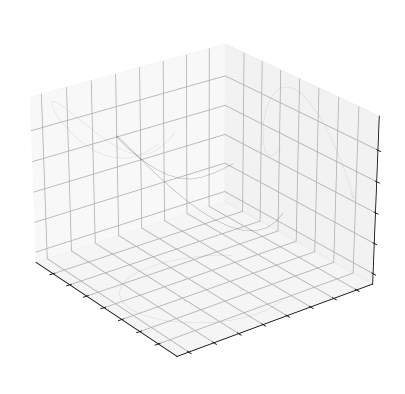

In [42]:
horizon = 2000
num_test = 1
pred = []
print(U.shape)
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    pred.append(Y_pred[0])
plt.figure(figsize=(20,10))
pred = np.array(pred).T
print(pred.shape)
plt.plot(pred.T)
plt.plot(U[0,test_start : test_start + horizon])

ncols = 1000
ustack = np.vstack([ pred[:,i:i+ncols] for i in range(nrows)])
Ml, Diag, Mr = np.linalg.svd(ustack, full_matrices=False)
plt.figure()
plt.plot(Diag, 'b*', label='sigular values')

N_v = 3
# Mr = ustack
plot3dproj(Mr[0], Mr[1], Mr[2], shadow_dist=2, elev_azim=(25,-37), linewidth=.15, show_labels=False)
plt.tight_layout()
plt.show()

In [92]:
print(U0.shape)
system_name = 'Chua'
U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[0]
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)

seed = 42
random.seed(seed) 
np.random.seed(seed)

inSize = U.shape[0]
outSize = inSize  
resSize = 100
a = 0.1           # leaking rate
K = 1.8          # spectial redius
reg = 1e-6       # regularization coefficient 
input_scaling = 1
ndelay = 10
use_delay = True

# generation of random weights
Win = (np.random.rand(resSize,1+inSize)-0.5) *2* input_scaling
W = np.random.rand(resSize,resSize)-0.5
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K 

if use_delay:
    Win[1:] = 0
    W[:ndelay] = 0
    W[1:ndelay,:ndelay-1] = np.eye(ndelay-1)

X = np.zeros((resSize,U.shape[1]))
x = np.zeros([resSize,1])

for t in tqdm(range(U.shape[1])):
    u = U[:,t:t+1]

    if use_delay:
        x[:ndelay] =  Win[:ndelay] @ np.vstack((1,u)) + W[:ndelay] @ x
        x[ndelay:] = (1-a) * x[ndelay:] + a * np.tanh( Win[ndelay:] @ np.vstack((1,u)) + W[ndelay:] @ x ) 
    else:
        x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x )        
    X[:,t:t+1] = x


# offline train
U_train = U[:,train_start : train_start + num_train]
X_train = X[:,train_start : train_start + num_train]
Y_train = U[:,train_start + 1 : train_start + num_train + 1]
H = np.vstack((np.ones((1,X_train.shape[1])),X_train))



Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)


horizon = 100
mse = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
#          
        if use_delay:
            X_test[:ndelay] =  Win[:ndelay] @ np.vstack((np.ones((1,num_test)),U_test)) + W[:ndelay] @ X_test
            X_test[ndelay:] = (1-a) * X_test[ndelay:] + a * np.tanh( Win[ndelay:] @ np.vstack((np.ones((1,num_test)),U_test)) + W[ndelay:] @ X_test )
        else:
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
            
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
    mse.append(np.average(np.square(Y_pred - Y_true)[0]))



(20000,)
dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (1, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

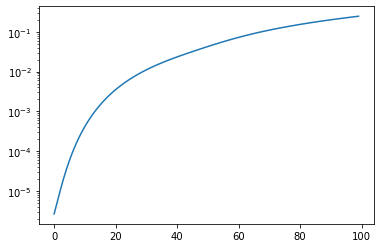

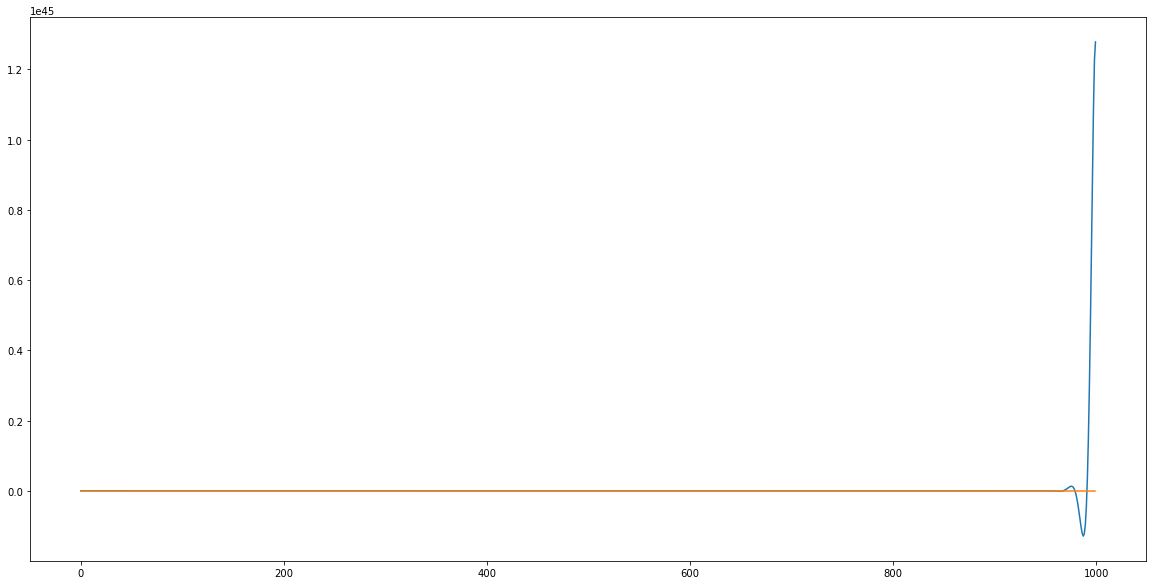

In [93]:
plt.figure()
plt.plot(mse) 
plt.yscale('log')


num_test = 1
horizon = 1000
pred = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        if use_delay:
            X_test[:ndelay] =  Win[:ndelay] @ np.vstack((np.ones((1,num_test)),U_test)) + W[:ndelay] @ X_test
            X_test[ndelay:] = (1-a) * X_test[ndelay:] + a * np.tanh( Win[ndelay:] @ np.vstack((np.ones((1,num_test)),U_test)) + W[ndelay:] @ X_test )
        else:
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
           
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    pred.append(Y_pred[0])

plt.figure(figsize=(20,10))
plt.plot(pred)
plt.plot(U[0,test_start : test_start + horizon])

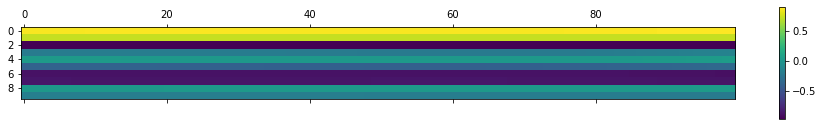

In [79]:
plt.matshow(X_train[:ndelay,:100])
plt.colorbar()

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


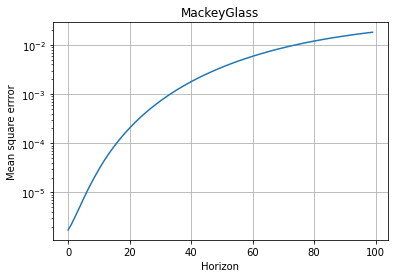

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


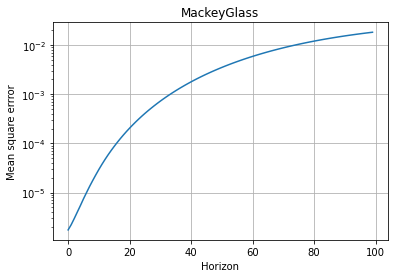

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


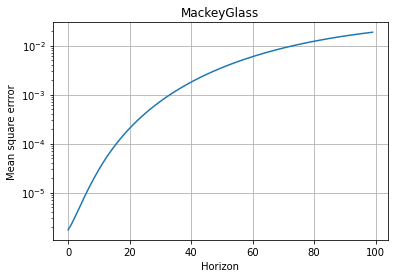

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


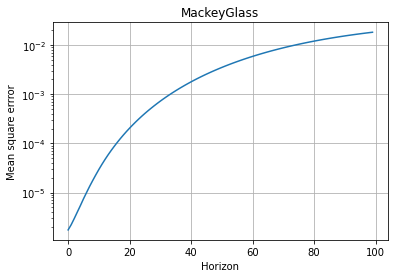

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


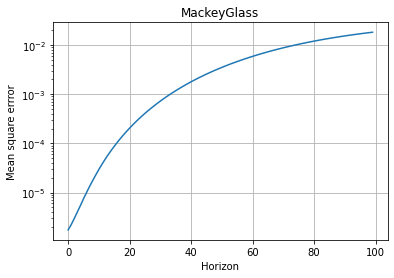

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


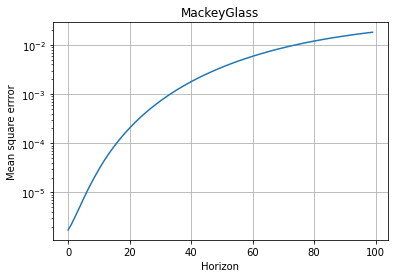

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


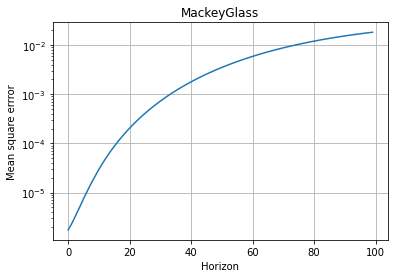

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


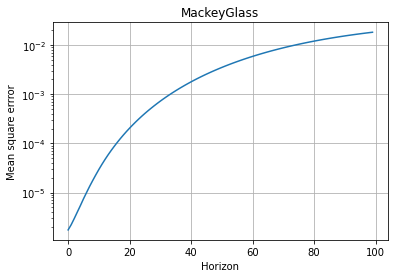

dataset shape: (1, 20000)
[66.80848489]
pre_output shape: (201, 10000)
W_out shape: (1, 201)


KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
import networkx as nx
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
plt.ion()
%matplotlib inline



class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))


path = 'result/predict_x'
if not os.path.exists(path):
    os.makedirs(path)


seed = 42
for degree in [0.1*i for i in range(1,10)]:
    for system_name in ['MackeyGlass']:
        # system_name = 'Rabinovich Fabrikant'
        # system_name = 'Lorenz'

        random.seed(seed) 
        np.random.seed(seed)


        mses = []
        dim = 1
        U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
        U0 = np.atleast_2d(U0)[:dim]
        U = U0 + np.random.randn(*U0.shape)*1e-3
        U = np.atleast_2d(U)
        num_prepare = 1000
        train_start = num_prepare
        num_train = 10000
        val_start = num_prepare + num_train
        num_val = 1000
        test_start = num_prepare + num_train + num_val
        num_test = 5000
        print('dataset shape:', U.shape)


        inSize = U.shape[0]
        outSize = inSize  
        resSize = 200
        a = 0.9           # leaking rate
        K = 0.99          # spectial redius
        reg = 1e-6       # regularization coefficient 
        input_scaling = 1


        # generation of random weights
        Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
        W = np.random.rand(resSize,resSize)-0.5
#         g = nx.erdos_renyi_graph(resSize, degree, seed, True)
#         W = nx.adjacency_matrix(g).todense().astype('float')
        # spectral radius: rho
        largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
        print(largest_eigvals)
        rhoW = np.sqrt(largest_eigvals[0])
        W = W/rhoW*(K-1+a)/a 
        X = np.zeros((resSize,U.shape[1]))

        is_transient = True
        initial_transients = [np.zeros([resSize,1]), np.ones([resSize,1]), -np.ones([resSize,1])]
        x = initial_transients[0]

        for t in range(U.shape[1]):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
            X[:,t:t+1] = x


        # offline train
        U_train = U[:,train_start : train_start + num_train]
        X_train = X[:,train_start : train_start + num_train]
        Y_train = U[:,train_start + 1 : train_start + num_train + 1]
        H = np.vstack((np.ones((1,X_train.shape[1])),X_train))



        Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
        print('pre_output shape:', H.shape)
        print('W_out shape:', Wout.shape)


        horizon = 100

        for h in range(horizon):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
    #         print(X_test, X.shape, U.shape)
            H = np.vstack((np.ones((1,num_test)),X_test))
            Y_pred = Wout @ H
            Y_true = U[:,test_start+h+1 : test_start + num_test + h + 1]
            mses.append(np.average(np.square(Y_pred - Y_true)[0]))

    plt.plot(mses)
    plt.yscale('log')
    plt.xlabel('Horizon')
    plt.ylabel('Mean square errror')
    plt.title(system_name)
    plt.grid('on')
    #     plt.savefig(path+'/multipred_'+system_name+'.pdf')
    plt.show()


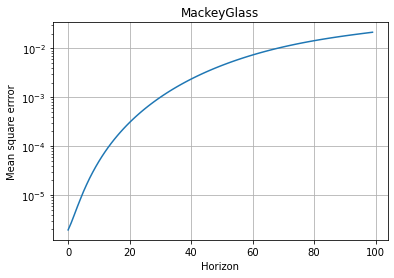

In [49]:
plt.plot(mses)
plt.yscale('log')
plt.xlabel('Horizon')
plt.ylabel('Mean square errror')
plt.title(system_name)
plt.grid('on')
#     plt.savefig(path+'/multipred_'+system_name+'.pdf')
plt.show()

In [52]:

for system_name in ['MackeyGlass']:
    
    U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    print(U0.shape)

    nhistory = [1] + [10*i for i in range(1,10)]
    mse_history = [[] for _ in range(len(nhistory))]

    for i,nrows in enumerate(nhistory):

        ncols = 19000
        ustack = np.vstack([ U0[i:i+ncols] for i in range(nrows)])

        U1 = np.vstack([ustack[-1], ustack[:-1]])


        U = U1 + np.random.randn(*U1.shape)*1e-3
        U = np.atleast_2d(U)
        num_prepare = 1000
        train_start = num_prepare
        num_train = 10000
        val_start = num_prepare + num_train
        num_val = 1000
        test_start = num_prepare + num_train + num_val
        num_test = 5000
        print('dataset shape:', U.shape)

        seed = 42
        random.seed(seed) 
        np.random.seed(seed)

        inSize = U.shape[0]
        outSize = inSize  
        resSize = 200
        a = 1         # leaking rate
        K = 0.99          # spectial redius
        reg = 1e-6       # regularization coefficient 
        input_scaling = 1

        # generation of random weights
        Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
        W = np.random.rand(resSize,resSize)-0.5

        largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])
        W = W/rhoW*(K-1+a)/a 
        X = np.zeros((resSize,U.shape[1]))

        is_transient = True
        initial_transients = [np.zeros([resSize,1]), np.ones([resSize,1]), -np.ones([resSize,1])]
        x = initial_transients[0]

        for t in tqdm(range(U.shape[1])):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
            X[:,t:t+1] = x


        # offline train
        U_train = U[:,train_start : train_start + num_train]
        X_train = X[:,train_start : train_start + num_train]
        Y_train = U[:,train_start + 1 : train_start + num_train + 1]
        H = np.vstack((np.ones((1,X_train.shape[1])),X_train))



        Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
        print('pre_output shape:', H.shape)
        print('W_out shape:', Wout.shape)


        horizon = 100

        for h in tqdm(range(horizon)):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
            H = np.vstack((np.ones((1,num_test)),X_test))
            Y_pred = Wout @ H
            Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
            mse_history[i].append(np.average(np.square(Y_pred - Y_true)[0]))
            
    for i in range(len(nhistory)):
        plt.plot(mse_history[i], label=str(nhistory[i]))  
    plt.yscale('log')
    plt.legend()
    plt.show()

    sns.heatmap(np.log(np.array(mse_history)))
    plt.show()

    plt.plot(np.array(mse_history)[:,-1])
    plt.yscale('log')
    import statsmodels.tsa.api as smt
    acf = smt.stattools.acf(U0,nlags=100,fft=True)
    plt.figure()
    plt.plot(acf)
    plt.grid('on')
    plt.show()


(20000,)
dataset shape: (1, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (201, 10000)
W_out shape: (1, 201)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (10, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (201, 10000)
W_out shape: (10, 201)


  0%|          | 0/100 [00:00<?, ?it/s]

dataset shape: (20, 19000)


  0%|          | 0/19000 [00:00<?, ?it/s]

pre_output shape: (201, 10000)
W_out shape: (20, 201)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/10000 [00:00<?, ?it/s]

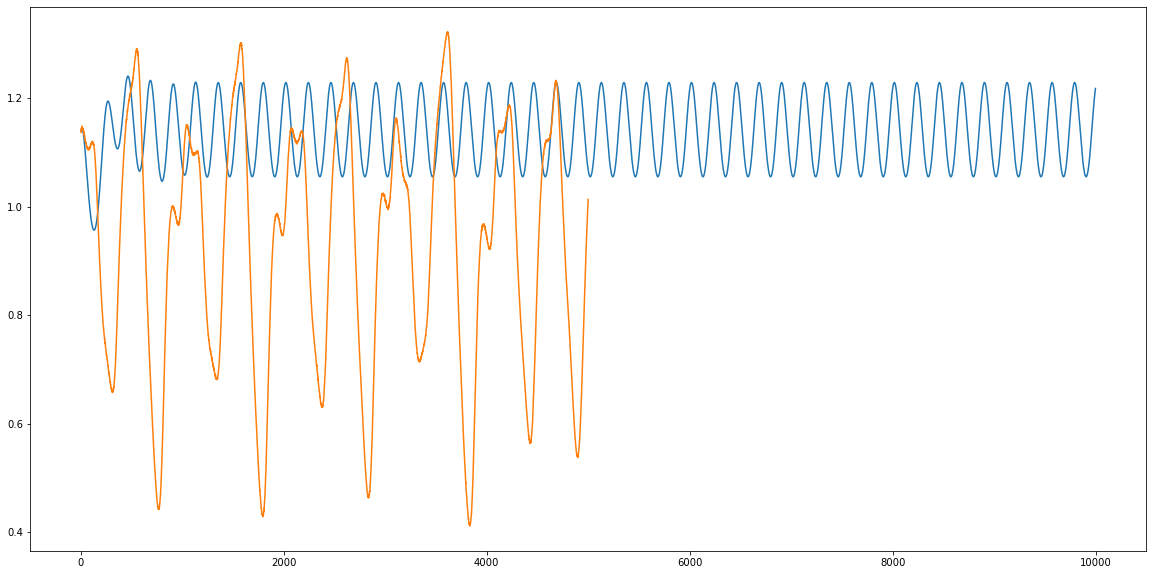

In [53]:
horizon = 10000
num_test = 1
pred = []
test_start = 14000
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    pred.append(Y_pred[0])
plt.figure(figsize=(20,10))
plt.plot(np.array(pred))
plt.plot(U[0,test_start : test_start + horizon])